## Problem 3 - Time based simulation approach

### 3.2

In [94]:
import numpy as np

class Vehicle:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.pickup_line_time = None
        self.serviced_time = None
        
    def set_pickup_line_time(self, time):
        self.pickup_line_time = time
    
    """
    Show the vehicle's state
    """
    def __str__(self):
        return f"Vehicle(arrival_time={self.arrival_time}, pickup_line_time={self.pickup_line_time}, serviced_time={self.serviced_time})"
    
    """
    Show the vehicles waiting times for each of the two transitions
    """
    def waiting_time(self):
        """
        Returns a nice dictionary with the waiting times for each of the three transitions
        """
        waiting_times = {}
        if self.pickup_line_time is not None:
            waiting_times["pickup_line"] = self.pickup_line_time - self.arrival_time
        if self.serviced_time is not None:
            waiting_times["serviced"] = self.serviced_time - self.pickup_line_time
        return waiting_times
        
        


def simulate(time_delta_seconds=1):
    time = 0
    dt = time_delta_seconds/60/60 # unit: hour, time step in seconds

    waiting_line = []
    pickup_line = []
    PICKUP_LINE_CAPACITY = 10
    serviced_customers = []

    lambda_arrive = 100 # Arrivals per hour
    mu_1 = 200
    mu_2 = 110

    line_length_stats = []



    while len(serviced_customers) < 10000:
        time += dt
        # Check if a new vehicle arrives
        arrived = np.random.poisson(lambda_arrive * dt)
        
        for _ in range(arrived):
            vehicle = Vehicle(time)
            waiting_line.append(vehicle)
            
        # Check if a vehicle can be moved to the pickup line
        amount_ready_to_go_pickup = np.random.poisson(mu_1 * dt)
        
        for _ in range(amount_ready_to_go_pickup):
            if len(waiting_line) > 0 and len(pickup_line) < PICKUP_LINE_CAPACITY:
                vehicle = waiting_line.pop(0)
                vehicle.set_pickup_line_time(time)
                pickup_line.append(vehicle)
        
        # Check if a vehicle can be serviced
        amount_serviced = np.random.poisson(mu_2 * dt)
        for _ in range(amount_serviced):
            if len(pickup_line) > 0:
                vehicle = pickup_line.pop(0)
                vehicle.serviced_time = time
                serviced_customers.append(vehicle)
                
        # To debug show current state of queues
        if False:
            print(f"Time: {time:.2f}, Waiting Line: {len(waiting_line)}, Pickup Line: {len(pickup_line)}, Serviced: {len(serviced_customers)}")
        # Collect statistics
        line_length_stats.append({"time": time, "waiting_line": len(waiting_line), "pickup_line": len(pickup_line), "serviced": len(serviced_customers)})
    
    return serviced_customers, line_length_stats

serviced_customers, line_length_stats = simulate()
        

In [102]:
import pandas as pd
df = pd.DataFrame(line_length_stats)
df

,time,waiting_line,pickup_line,serviced
0,0.000278,0,0,0
1,0.000556,0,0,0
2,0.000833,0,0,0
3,0.001111,0,0,0
4,0.001389,0,0,0
...,...,...,...,...
360313,100.087222,2,3,9999
360314,100.087500,2,3,9999
360315,100.087778,2,3,9999
360316,100.088056,2,3,9999


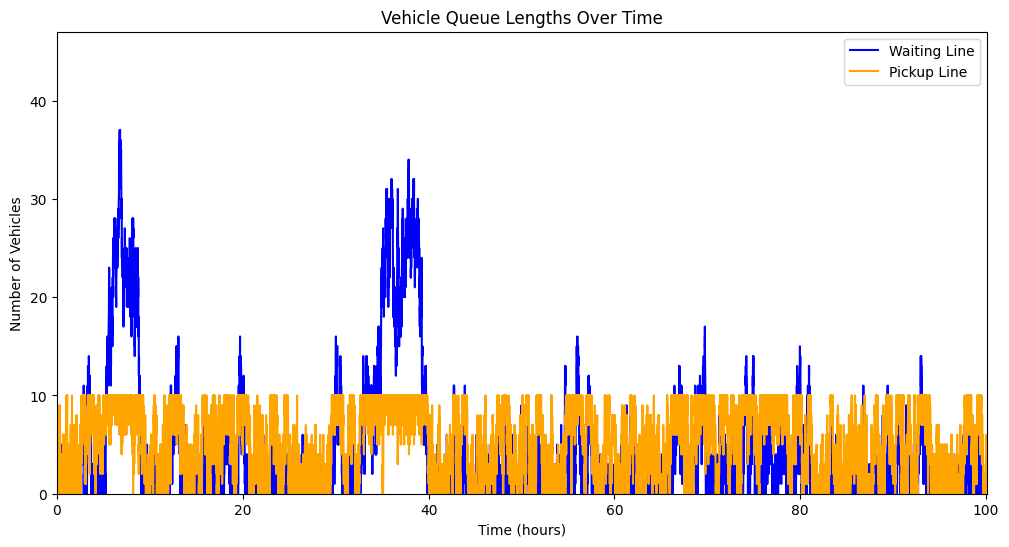

In [103]:
import matplotlib.pyplot as plt

# Plot the length of the waiting line and pickup line over time
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['waiting_line'], label='Waiting Line', color='blue')
plt.plot(df['time'], df['pickup_line'], label='Pickup Line', color='orange')

plt.xlim(0, df['time'].max())
plt.ylim(0, max(df['waiting_line'].max(), df['pickup_line'].max()) + 10)




plt.xlabel('Time (hours)')
plt.ylabel('Number of Vehicles')
plt.title('Vehicle Queue Lengths Over Time')
plt.legend()
plt.show()

In [104]:
cars = pd.DataFrame()

for car in serviced_customers:
    car_stats = car.waiting_time()
    car_stats["arrival_time"] = car.arrival_time
    car_stats["pickup_line_time"] = car.pickup_line_time
    car_stats["serviced_time"] = car.serviced_time
    cars = pd.concat([cars, pd.DataFrame(car_stats, index=[0])], ignore_index=True)

cars

,pickup_line,serviced,arrival_time,pickup_line_time,serviced_time
0,0.005556,0.006111,0.014722,0.020278,0.026389
1,0.006944,0.010556,0.014722,0.021667,0.032222
2,0.001667,0.005556,0.027500,0.029167,0.034722
3,0.000000,0.010278,0.031389,0.031389,0.041667
4,0.002500,0.006667,0.032778,0.035278,0.041944
...,...,...,...,...,...
9995,0.025000,0.035556,99.993056,100.018056,100.053611
9996,0.025556,0.033056,99.997778,100.023333,100.056389
9997,0.004444,0.043056,100.019722,100.024167,100.067222
9998,0.003056,0.046389,100.027500,100.030556,100.076944


In [98]:
sum(cars["arrival_time"] < 1)

114

In [100]:
# Plot the total amount of cars having entered each queue
# Do time steps checking how many cars have entered each line at that time step
# We do not care if they have passed onto another step, just if they have entered
# eg. the plot is cumulative
plt.figure(figsize=(12, 6))
cumulative_df = pd.DataFrame()
for time in np.arange(0, df['time'].max(), 0.05):
    # Count amount in arrival line
    amount_arrived = sum(cars["arrival_time"] < time)
    # Count amount in pickup line
    amount_pickup = sum(cars["pickup_line_time"] < time)
    # Count amount serviced
    amount_serviced = sum(cars["serviced_time"] < time)
    
    cumulative_df = pd.concat([cumulative_df, pd.DataFrame({"time": time, "arrived": amount_arrived, "pickup_line": amount_pickup, "serviced": amount_serviced}, index=[0])], ignore_index=True)
    

cumulative_df
    

,time,arrived,pickup_line,serviced
0,0.00,0,0,0
1,0.05,6,5,5
2,0.10,11,11,10
3,0.15,23,22,18
4,0.20,26,26,25
...,...,...,...,...
1997,99.85,9980,9980,9980
1998,99.90,9984,9984,9983
1999,99.95,9990,9990,9988
2000,100.00,9997,9993,9993


<Figure size 1200x600 with 0 Axes>

### 3.3

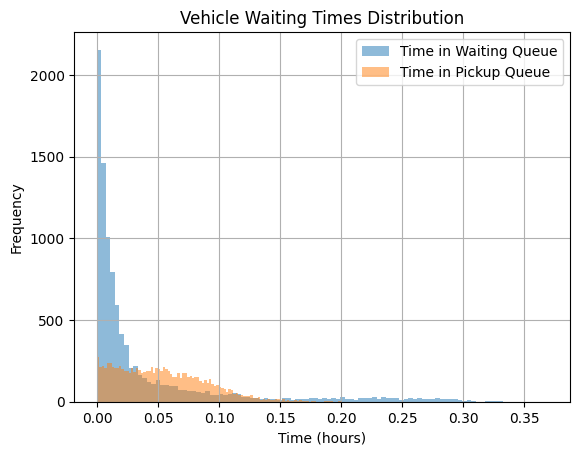

In [129]:
cars.pickup_line.hist(bins=100, alpha=0.5, label="Time in Waiting Queue")
cars.serviced.hist(bins=100, alpha=0.5, label="Time in Pickup Queue")

plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Vehicle Waiting Times Distribution')
# Make the y-axis logarithmic
plt.show()

### 3.4

In [135]:
# Do simulation 10 times

sims = [ simulate(time_delta_seconds=5 ) for _ in range(10)]

# Calculate average waiting times for each simulation
for sim in sims:
    waiting_times = []
    for car in sim[0]:
        waiting_times.append(car.waiting_time()["pickup_line"] + car.waiting_time()["serviced"])
    avg_waiting_time = np.mean(waiting_times)
    
    print(f"Average waiting time for simulation: {60*avg_waiting_time:.3f} minutes")
    
    


Average waiting time for simulation: 7.621 minutes
Average waiting time for simulation: 5.825 minutes
Average waiting time for simulation: 4.975 minutes
Average waiting time for simulation: 7.126 minutes
Average waiting time for simulation: 6.496 minutes
Average waiting time for simulation: 5.087 minutes
Average waiting time for simulation: 8.340 minutes
Average waiting time for simulation: 5.471 minutes
Average waiting time for simulation: 5.975 minutes
Average waiting time for simulation: 7.395 minutes
